# Welter issue #1
## Telluric Absorption Lines and Spectral Shape
### Part 3- Characterizing the sub pixel shift

Michael Gully-Santiago  
Friday, November 27, 2015  


In the [previous notebook](welter_issue001-How_bad_is_bare_telluric-02.ipynb), we saw that blindly dividing by the telluric response is not actually that bad.  However we anticipate that we will encounter problems whereby we have to apply sub-pixel shifts to the telluric spectrum in order to get them to line up with the target star.

In this notebook, we characterize the sub pixel shifts with cross-correlation.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
hdu_raw = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCH_20151117_0199.spec.fits')
hdu_f   = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCH_20151117_0199.spec_flattened.fits')
hdu_var = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCH_20151117_0199.variance.fits')
hdu_tar = fits.open('../data/raw/LkCa4_gully/outdata/20151117/SDCH_20151117_0205.spec.fits')
hdr = hdu_tar[0].header

## Import the telluric model.

In [4]:
import pandas as pd

In [5]:
!head /Users/gully/GitHub/plp/master_calib/TelluricModel.dat

1.399999455764457480e+03 2.026157019940910686e-15
1.400002455764457409e+03 1.795464683522225817e-15
1.400005455764457338e+03 1.657146761063786336e-15
1.400008455764457267e+03 1.327970617299517754e-15
1.400011455764457196e+03 1.034897410552782828e-15
1.400014455764457125e+03 7.978464170274487424e-16
1.400017455764457054e+03 5.531161372366388933e-16
1.400020455764456983e+03 3.825528930996745532e-16
1.400023455764456912e+03 1.982228986651982812e-16
1.400026455764456841e+03 9.481807664948915310e-17


In [6]:
tell_fn = '/Users/gully/GitHub/plp/master_calib/TelluricModel.dat'

In [7]:
tell = pd.read_csv(tell_fn, sep=' ', names = ['wavelength', 'trans'])
tell.head()

,wavelength,trans
0,1399.999456,2.026157e-15
1,1400.002456,1.795465e-15
2,1400.005456,1.657147e-15
3,1400.008456,1.327971e-15
4,1400.011456,1.034897e-15


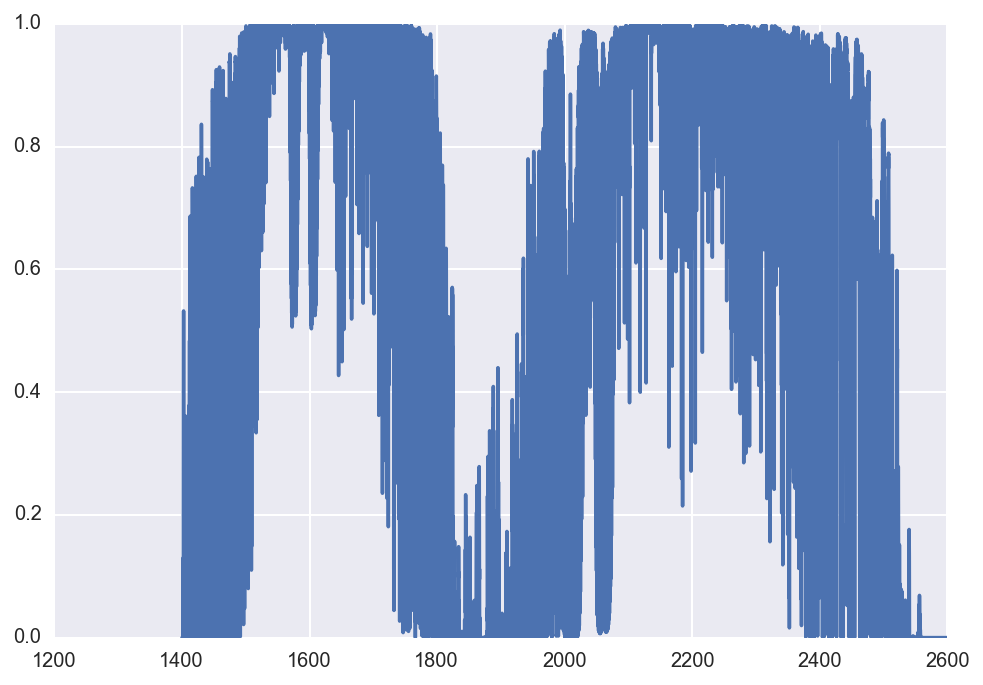

In [8]:
plt.plot(tell.wavelength, tell.trans)

## The problem: What is the sub-pixel shift?

First we do a cross correlation and then look at the peak in detail.

In [9]:
from scipy import signal

In [10]:
o=10

In [11]:
t_inst = hdu_raw[0].data[o, :] / hdu_f[0].data[o, :] 
t_oplus = hdu_f[0].data[o, :] 

In [12]:
dx0, dx1 = 350, 1500 #Pick the middle 1000 pixels
sub_sample_y = hdu_f[0].data[o, dx0:dx1]
sub_sample_x = hdu_raw[1].data[o, dx0:dx1]

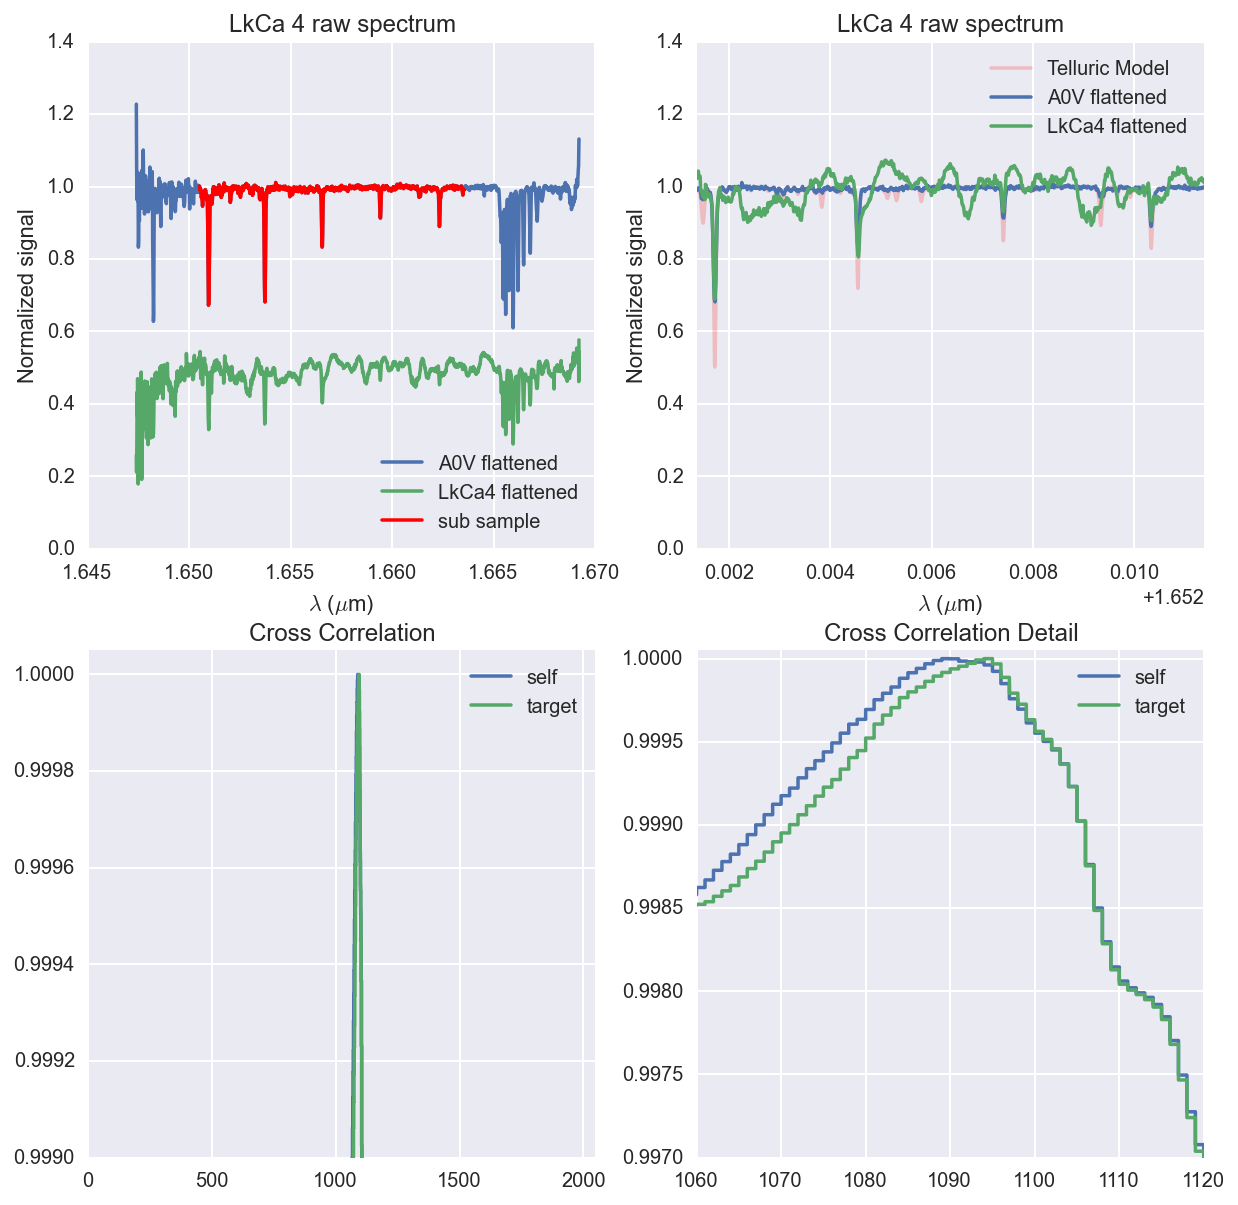

In [13]:
tar_f = hdu_tar[0].data[o, :] / t_inst
cor1 = signal.correlate(tar_f/0.5, hdu_f[0].data[o, dx0:dx1], mode='same')
cor2 = signal.correlate(tar_f/0.5, tar_f[dx0:dx1]/0.5, mode='same')
x = np.arange(2048)

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.plot(hdu_tar[1].data[o, :], tar_f, label='LkCa4 flattened')
plt.plot(hdu_raw[1].data[o, dx0:dx1], hdu_f[0].data[o, dx0:dx1], 'r', label='sub sample')
plt.legend(loc='best')
plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));

plt.subplot(222)
plt.plot(tell.wavelength/1000.0, tell.trans, 'r', alpha=0.2, label='Telluric Model')
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.plot(hdu_tar[1].data[o, :], tar_f/0.5, label='LkCa4 flattened')
plt.legend(loc='best')
plt.ylim(ymin=0)
x_c = hdu_raw[1].data[o, 1024]
plt.xlim(x_c-0.005, x_c+0.005)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));


plt.subplot(223)
c1n = cor1/np.nanmax(cor1)
c2n = cor2/np.nanmax(cor2)
plt.step(x, c1n, label='self')
plt.step(x, c2n, label='target')
plt.ylim(0.999, 1.00005)
#plt.xlim(1160, 1180)
plt.xlim(x[0], x[-1])
plt.title('Cross Correlation')
plt.legend(loc='best');

x_max = np.nanargmax(cor1)

plt.subplot(224)
plt.step(x, c1n, label='self')
plt.step(x, c2n, label='target')
plt.ylim(0.99700, 1.00005)
window = 60
plt.xlim(x_max-window/2.0, x_max+window/2.0)
plt.title('Cross Correlation Detail')
plt.legend(loc='best');

**This is hard.**  If you change `dx0` and `dx1`, you get different answers, showing that the result is strongly dependent on the choice of wavelength range, and ambient noise level.  And the shifts (in this case at least) are so small that it's hard to discern them, if they're present at all.  And since they're sub-pixel, you have to do something clever to measure them-- either interpolation or regression.  But fitting a Gaussian to them is tricky because not every peak looks like a Gaussian.  So yeah, it's hard.  Or at least involved.  

I am certain this problem has been solved before, in better ways.  But I can't seem to find great content on the web.  I have found a few packages that try to solve similar problems, but I haven't been able to get them to work.  Admittedly, I didn't try very hard, since Python 2/3 clashes made me inclined to just do something simple on my own to get a 'feel' for the sub-pixel shifts.  Here are some of the resources I found:

- [Hyperspy](http://www.hyperspy.org) offers some interesting [Spectrum tools](http://hyperspy.org/hyperspy-doc/current/user_guide/spectrum.html), including "sub-pixel cross-correlation or user-provided shifts to align spectra".
- [Image Registration](https://github.com/keflavich/image_registration) is Adam Ginsburg's system for matching extended objects at sub-pixel resolution.  He uses FFT's and seems to "do it right". 

I'm going to close this issue for now.

### The end.